_THIBOUD Pierre-Eliott_  
_PERIER-CAMBY Julien_


# IBI - Algorithmes génétiques TP



In [1]:
from blackbox37 import check
import string
import random
from matplotlib import pyplot as plt
%matplotlib inline

from cross_overs import CrossOverRandomSliceTwo, CrossOverRandomTwo
from explorations import RandomExploration, SimpleExploration, TerraExploration
from mutations import NCharRandomMutation, NCharNextPrevMutation, NCharSeqMutation, NCharSeqNextPrevMutation
from population import Population, Individual

## Liste des caractères à utiliser

In [3]:
available_characters = list(string.ascii_uppercase) + [str(i) for i in range(10)]
available_characters.append("")
GROUP_ID = 2

In [4]:
print(available_characters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '']


## Les individus

In [58]:
from population import generate
i = Individual(generate())
print('Genotype:', i.genotype)
print('Phenotype:', i.phenotype())

Genotype: ['0', 'C', 'F', '', 'U', 'Z', 'R', '9', '4', 'Y', 'B', 'A', 'A', 'M', 'A', 'L', 'S', 'G']
Phenotype: 0CFUZR94YBAAMALSG


Le génotype d'un individu est une liste de 18 caractères, qui peuvent être le caractère vide, et le phénotype de celui ci est simplement la concaténation de tous les caractères.

## Affichage des résultats d'une évolution

In [2]:
def plot_results(average, bests, details):
    plt.figure(figsize=(20, 7))
    plt.plot(average, color='green', linestyle='dotted', label='Moyenne de la population actuelle')
    plt.plot(bests, color='red', label='Maximum trouvé')
    plt.xlabel('Itérations')
    plt.ylabel('Scores')
    plt.legend(loc="lower right")
    if details:
        if details['title']:
            plt.suptitle(details['title'], y=0.97, fontsize=18)
        if details['subtitle']:
            plt.title(details['subtitle'])
    plt.show()

# Evolution des populations

In [3]:
def evolve_population(population, max_epochs=1000, show_progress=False, progress_step=10, show_if_found=True):
    averages = []
    bests = []
    best = population.population[0]
    for epoch in range(max_epochs):
        population.evaluate()
        b = population.get_max()
        best = b if b.score > best.score else best
        bests.append(best.score)
        average = population.get_average_score()
        averages.append(average)

        if show_progress:
            print(f"Epoch {epoch + 1}/{max_epochs}: Best {best.phenotype()} ({best.score}) (average: {average})")

        if best.score == 1.0 and show_if_found:
            print(f"Best found: {best.phenotype()} at Epoch {epoch + 1}/{max_epochs}!")
            break

        population.evolve()
    return averages, bests, best

## Recherche de la solution

In [4]:
def search(population_size=100, epochs=100):
    cross_over = CrossOverRandomSliceTwo(0.9)
    mutation = NCharRandomMutation(n=1)
    exploration = TerraExploration(cross_over, mutation, elite_size=10, 
                                   pop_size=population_size, reunion=30, continents=(0.3, 0.15, 0.35, 0.2))
    
    population = Population(population_size, exploration=exploration)
    averages, bests, best = evolve_population(population, max_epochs=epochs, show_progress=False)
    print(f"Best solution found: {best.phenotype()} ({best.score:.3f})")
    details = {
        'title': f"Evolution population de taille {population_size}",
        'subtitle': f"Best solution found: {best.phenotype()} ({best.score:.3f})"
    }
    plot_results(averages, bests, details)

Best solution found: GZYLGRO1FUUV94 (0.958)


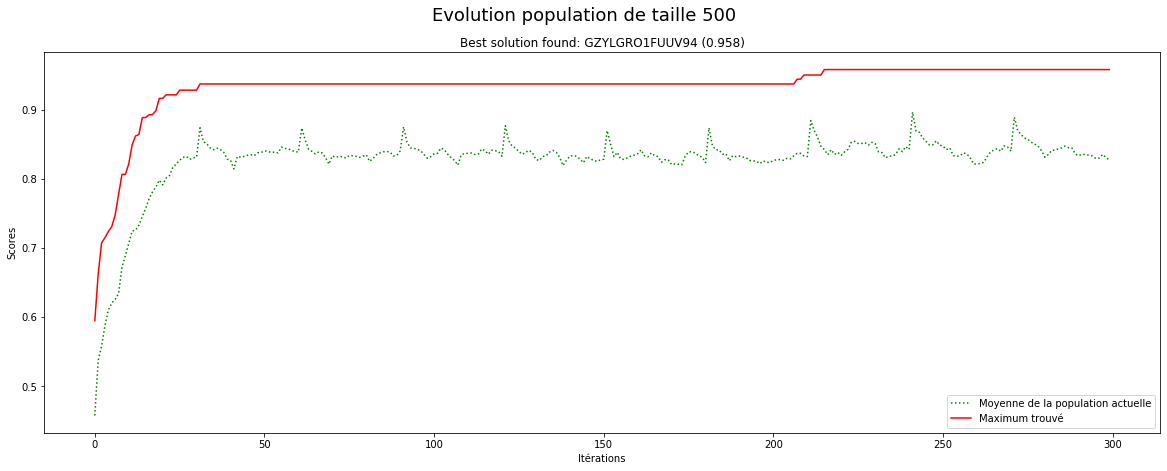

In [21]:
search(500, 300)

Best found: GZYLGRO1FHUHUV94 at Epoch 176/300!
Best solution found: GZYLGRO1FHUHUV94 (1.000)


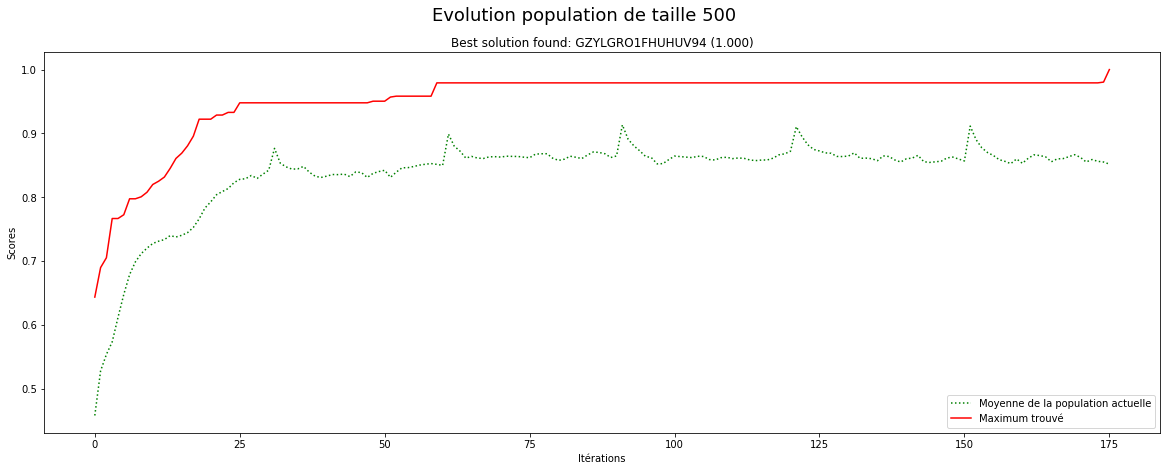

In [11]:
search(500, 300)

In [20]:
print('GZYLGRO1FHUHUV94 =',check(group_number=GROUP_ID, attempt='GZYLGRO1FHUHUV94'))
print("Mot de passe trouvé !")

GZYLGRO1FHUHUV94 = 1.0
Mot de passe trouvé !


Sur ce graphique, on peut apercevoir les fusions des différentes populations grâce au pic que connaît la moyenne de la population totale. Ceci s'explique par le fait que lors d'une fusion, certaines populations qui avaient "perdu" des gènes positifs au cours de leur évolution se retrouvent au contact du "gène manquant", ce qui augmente leur score et donc la moyenne de l'ensemble de la population.

On remarque également des périodes de stagnation entre les fusions et des fusions qui ont un impact limité (seule la 2e a produit un nouveau meilleur élément). On peut interpréter ceci par un manque de diversité génétique entre les reproducteurs des différentes populations. En effet, une sélection élitiste des reproducteurs induira une conservation de gènes très similaires dans des populations différentes. Ajouté à cela cette même sélection lors des fusions, on obtient une proportion plus importante de bons individus mais une diversité génétique plus faible.  
Pour compenser ceci, il faudrait mettre en place une sélection autre qu'élitiste, ou augmenter l'exploration entre les fusions, soit par une périodicité plus longue, soit par un nombre de mutations accru.

# Stats
Nous allons utiliser cette fonction afin de tester différentes configurations en moyennant les résultats sur plusieurs essais.

In [5]:
def stats(configs, nb_repeats):
    to_plot = []
    for i, conf in enumerate(configs):
        print(i, end=', ')
        repeats = []
        for i in range(nb_repeats):
            if 'exploration' in conf and conf['exploration'] == 'Terra':
                exploration = TerraExploration(conf['cross_over'],
                                                conf['mutation'],
                                                elite_size=conf['elite_size'], 
                                                pop_size=conf['population_size'], 
                                                continents=conf['continents'], 
                                                reunion=conf['reunion'])
            else:
                exploration = SimpleExploration(conf['cross_over'],
                                                conf['mutation'],
                                                elite_size=conf['elite_size'])
            population = Population(conf['population_size'], exploration=exploration)
            _, bests, _ = evolve_population(population, max_epochs=conf['epochs'], show_progress=False, show_if_found=False)
            repeats.append(bests)
        average = []
        for i in range(conf['epochs']):
            s = 0
            for r in repeats:
                s += r[i]
            average.append(s/nb_repeats)
        to_plot.append(average)
    
    plt.figure(figsize=(20, 7))
    for i, l in enumerate(to_plot):
        c = configs[i]
        label = f"Pop:{c['population_size']} Elite:{c['elite_size']} {str(type(c['mutation'])).split('.')[-1][:-2]}(n={c['mutation'].n}) {str(type(c['cross_over'])).split('.')[-1][:-2]}(proba={c['cross_over'].prob})"
        if 'exploration' in conf:
            label += ' ' + conf['exploration'] + 'Exploration'
        plt.plot(l, label=label)
    plt.xlabel('Itérations')
    plt.ylabel('Scores')
    plt.legend(loc="lower right")
    plt.show()

## Tailles des populations et élitisme

Nous allons utiliser des tailles de population allant de 100 à 1000 et des tailles d'élites de 10 à 50.

0, 1, 2, 3, 4, 5, 6, 

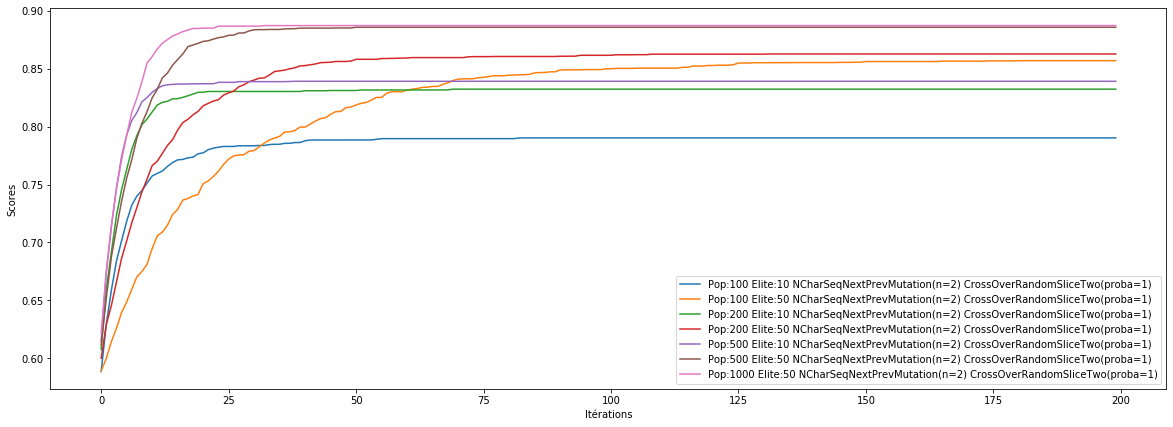

In [40]:
configs = [
        {
        'population_size': 100,
        'elite_size': 10,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(1),
    },
    {
        'population_size': 100,
        'elite_size': 50,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(1),
    },
    {
        'population_size': 200,
        'elite_size': 10,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(1),
    },
    {
        'population_size': 200,
        'elite_size': 50,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(1),
    },
        {
        'population_size': 500,
        'elite_size': 10,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(1),
    },
    {
        'population_size': 500,
        'elite_size': 50,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(1),
    },
    {
        'population_size': 1000,
        'elite_size': 50,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(1),
    }
]
stats(configs, nb_repeats=25)

On constate sur ces 25 répétitions, la meilleure combinaison est une population de taille 1000 avec une elite de taille 50. Néanmoins, cette taille de population implique de longs temps de calculs, nous avons donc choisit de prendre une taille de 500, qui a offert une convergence à peine plus lente, mais pour des résultats finaux similaires.

## Mutations

Nous avons implémenté 4 types de mutations différents :
 * `NCharRandomMutation`: Modifie N caractères dans le genotype de façon aléatoire.
 * `NCharNextPrevMutation`: Modifie N caractères choisis aléatoirement en remplaçant chaque caractère par un caractère _à coté_ dans `available_characters`.
 * `NCharSeqMutation`: Modifie une séquence de N caractères consécutifs de façon aléatoire.
 * `NCharSeqNextPrevMutation`: Modifie une séquence de N caractères consécutifs en remplaçant chaque caractère par un caractère _à coté_ dans `available_characters`.  

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

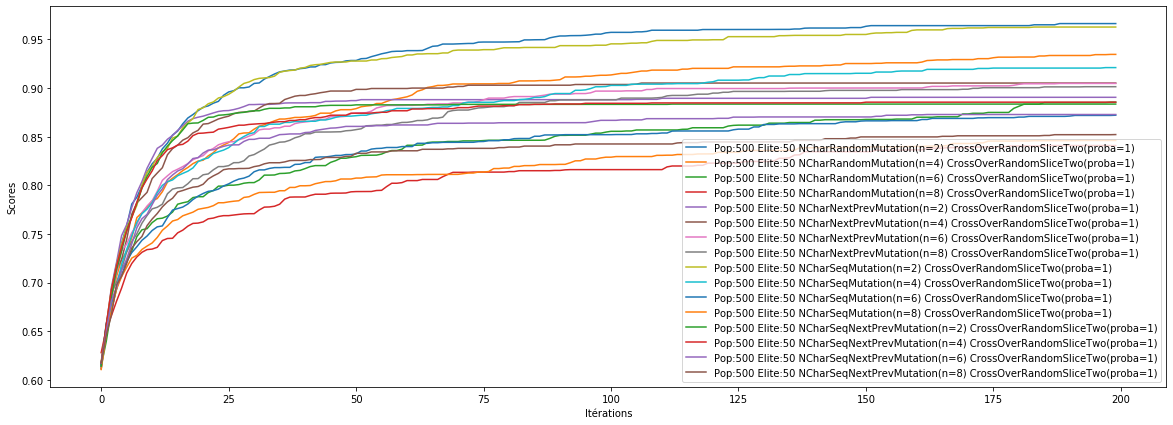

In [46]:
configs = []
mutations_types = [NCharRandomMutation, NCharNextPrevMutation, NCharSeqMutation, NCharSeqNextPrevMutation]
for mt in mutations_types:
    for n in (2, 4, 6, 8):
        configs.append({
            'population_size': 500,
            'elite_size': 50,
            'epochs': 200,
            'mutation': mt(n=n),
            'cross_over': CrossOverRandomSliceTwo(1),
        })
stats(configs, nb_repeats=15)

On constate que les configurations qui convergent le mieux sont `NCharRandomMutation (n=2)` et `NCharSeqMutation (n=2)`.
Cela nous laisse penser que la proximité des caratères dans l'ordre alphabétique n'est pas un facteur important de la fitness. De plus, un petit nombre de caractères à modifier semble donner de meilleurs résultats, ce qui semble logique car un nombre trop élevé ne permet pas des changements assez fins qui permettent d'améliorer une solution déjà bonne (cela peut même la dégrader plus facilement). Enfin, les changements sous forme de séquence plutot que de caractères aléatoirement choisits ne semble pas

## Cross-overs

Nous avons implémenté 2 types de cross-over différents :
 * `CrossOverRandomTwo`: Choisit 2 parents aléatoirement dans l'élite et choisit pour chaque gène un parent qui donnera ce gène aléatoirement.
 * `CrossOverRandomSliceTwo`: Choisit 2 parents aléatoirement dans l'élite et produit un individu en coupant de façon aléatoire les génomes des parents.
 
Les cross-over ont une probabilité de se produire, dans le cas où elle ne se produit pas, le nouvel individu est seulement muté.

0, 1, 2, 3, 4, 5, 6, 7, 

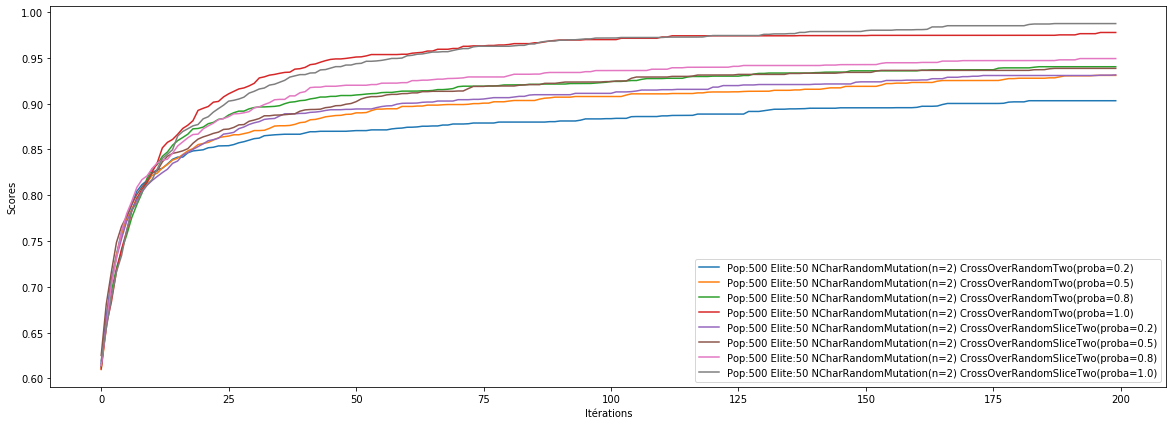

In [51]:
configs = []
co_types = [CrossOverRandomTwo, CrossOverRandomSliceTwo]
for cot in co_types:
    for prob in (0.2, 0.5, 0.8, 1.0):
        configs.append({
            'population_size': 500,
            'elite_size': 50,
            'epochs': 200,
            'mutation': NCharRandomMutation(n=2),
            'cross_over': cot(prob),
        })
stats(configs, nb_repeats=15)

D'après ces résultats, une probabilité de cross over égale à 1 est favorable. On constate que le cross-over aléatoire a une convergence un peu plus rapide, néanmoins, le fait d'utiliser des tranches de génomes semble mener à de meilleurs résultats, ce qui semble logique car cela permet de conserver certains patterns qui peuvent être détruits par les mutations aléatoirement placées.

## Types d'exploration

0, 1, 2, 3, 4, 5, 6, 7, 

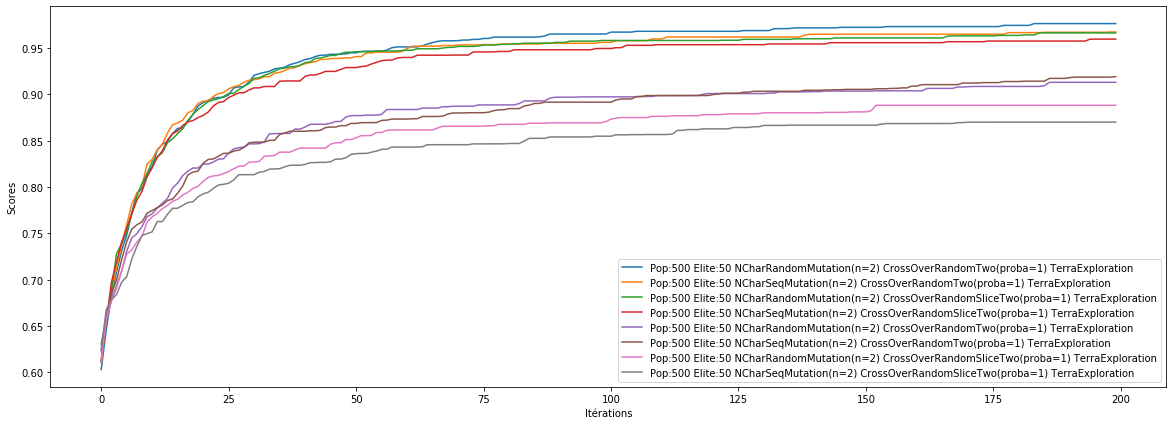

In [6]:
configs = []
mutations_types = [NCharRandomMutation, NCharSeqMutation]
co_types = [CrossOverRandomTwo, CrossOverRandomSliceTwo]
explorations = ['Terra', 'Simple']
for explo in explorations:
    for cot in co_types:
        for mt in mutations_types:
            configs.append({
                'population_size': 500,
                'elite_size': 50,
                'epochs': 200,
                'mutation': mt(n=2),
                'cross_over': cot(1),
                'exploration': explo,
                'continents': (0.1, 0.2, 0.15, 0.25, 0.1, 0.2),
                'reunion': 50,
            })
stats(configs, nb_repeats=10)

_NB: Un problème d'affichage s'est glissé dans le graphique, les 4 premières courbes correspondent bien à une Exploration Terra, mais les 4 dernières correspondent à une Simple._

On constate bien que l'exploration Terra permet de meilleures performances que notre exploration originale.

# Synthèse

Malgré une certaine variété dans les différentes composantes implémentées (explorations, cross-overs, mutations), il y a un certain nombre d'évolutions que nous aurions souhaité apporter telles qu'une évolutivité de la taille de la population (augmentation, diminution, ou changement aléatoire), des méthodes de sélection plus variées (suivant une loi normale, le rang, une roulette, une roulette améliorée, [l'équation du sélectionneur](https://fr.wikipedia.org/wiki/Génétique_quantitative#Génétique_quantitative_multivariée)), ou encore une certaine variabilité intrinsèque des paramètres (une périodicité de réunion _(TerraExploration)_ plus aléatoire, des tailles de continents variables au cours du temps).

Néanmoins, le travail effectué nous a permis de ressortir quelques principes généraux sur l'impact positif ou négatif de tel ou tel paramètre.  
Tout d'abord, la diversité génétique est clef dans la découverte de solutions pertinentes. En effet, malgré l'intérêt de renforcer l'intérêt des individus avec la meilleure fitness car ils sont probablement plus proches de la solution, il reste nécessaire de continuer à explorer l'espace à la recherche d'indices supplémentaires. Tout comme pour la recherche de minerais précieux : l'exploitation d'un filon est pertinente, mais la recherche de nouveaux filons n'est pas à négliger. Ainsi, la mise en place de stratégies de sélection plus variées auraient pu amener des résultats plus intéressants.  
Ensuite, de par le fonctionnement même du génotype, l'émergence de patterns "avantageux" est naturelle et particulièrement intéressante. Il faut ainsi s'atteler à explorer l'espace en conservant tout ou partie de ces patterns, pour augmenter par la même occasion la probabilité de découvrir une version améliorée de ce pattern, plus proche de la solution finale.  
En ce qui concerne les mutations, nous avons constaté que pour ce problème, un nombre de mutations limité (deux charactères) était plus efficace pour converger (cela permet des changements plus _fins_ et donc de mieux trouver la bonne solution à partir d'individus proches san)